In [1]:
from IPython.core.display import Markdown, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import traceback
import numpy as np
import scipy.stats as ss
import yaml
import itertools
import sys
import os
import subprocess
from os import path
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

def printmd(*args):
    display(Markdown(' '.join(map(str, args))))

def print_warn(*args):
    printmd(f"<code><font style='background-color:yellow;font-family:monospace'>{' '.join(map(str, args))}</font></code>")

In [2]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning/*" -s

In [3]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning_gen_circles/*" -s

In [4]:
local_planner_color = {'dwb': 'blue', 'rpp': 'orange', 'teb': 'green', 'rpp_bad': 'yellow'}
local_planner_symbol = {'dwb': 'o', 'rpp': '^', 'teb': 'x', 'rpp_bad': 's'}
robot_model_color = {'hunter': 'cyan', 'turtle': 'green'}
pd.options.display.width = 500
pd.options.display.max_rows = 0
pd.options.display.float_format = '{:,.3f}'.format
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.axisbelow'] = True

# plt.rcParams['lines.markersize'] = 3
# plt.rcParams['lines.marker'] = 'o'

# fg_color = 'white'
# plt.rcParams['grid.color'] = 'gray'
# plt.rcParams['text.color'] = fg_color
# plt.rcParams['ytick.color'] = fg_color
# plt.rcParams['xtick.color'] = fg_color
# plt.rcParams['axes.labelcolor'] = fg_color
# plt.rcParams['axes.edgecolor'] = fg_color

# bg_color = "#323a48"
# plt.rcParams['figure.facecolor'] = bg_color
# plt.rcParams['axes.facecolor'] = bg_color
# plt.rcParams['legend.facecolor'] = bg_color

In [5]:
df = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results.csv"))
with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results_info.yaml")) as results_info_file:
    results_info = yaml.safe_load(results_info_file)

# df_real = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results.csv"))
# with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results_info.yaml")) as results_real_info_file:
#     results_real_info = yaml.safe_load(results_real_info_file)
# df_real = df_real[(df_real.amcl_alpha_factor.notna()) & (df_real.robot_model=='turtlebot3_waffle_performance_modelling')]

# df_gen = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning_gen_circles/results.csv"))
# with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning_gen_circles/results_info.yaml")) as results_gen_info_file:
#     results_gen_info = yaml.safe_load(results_gen_info_file)

# df = df_gen.append(df_real, sort=True)

df.rename(inplace=True, columns={
    'collisionless_localization_update_absolute_translation_error_mean': 'absolute_translation_error',
    'collisionless_localization_update_absolute_rotation_error_mean': 'absolute_rotation_error',
    'collisionless_localization_update_relative_translation_error_mean': 'relative_translation_error',
    'collisionless_localization_update_relative_rotation_error_mean': 'relative_rotation_error',
    'collisionless_localization_update_normalized_relative_translation_error_mean': 'normalized_relative_translation_error',
    'collisionless_localization_update_normalized_relative_rotation_error_mean': 'normalized_relative_rotation_error',
    'localization_update_rate_mean': 'localization_update_rate',
    'localization_node': 'localization',
    'local_planner_node': 'local_planner',
    'global_planner_node': 'global_planner',
})
results_info['run_parameter_names'] = [s.replace('_node', '') for s in results_info['run_parameter_names']]
# results_info = results_gen_info
# results_info['run_parameter_names'] += [i for i in results_real_info['run_parameter_names'] if i not in results_info['run_parameter_names']]

# only consider real localization
df = df[df.localization != 'localization_generator']

# only consider amcl_alpha_factor if 0.0, 0.5, 1.0, or 2.0
# df = df[df.amcl_alpha_factor == 1.0]
df = df[df.amcl_alpha_factor.isin([0.0, 0.5, 1.0, 2.0])].copy()

# turn odometry_error into beta..4
results_info['run_parameter_names'] += ['beta', 'beta_2', 'beta_3', 'beta_4']
results_info['run_parameter_names'].remove('odometry_error')
for i in range(0, 4):
    df[f'beta_{i+1}'] = df['odometry_error'].apply(lambda x: eval(x)[i])
del df['odometry_error']

df['beta'] = df['beta_1']

df.loc[df.robot_model == 'turtlebot3_waffle_performance_modelling', 'robot_model'] = 'turtle'
df.loc[df.robot_model == 'hunter2', 'robot_model'] = 'hunter'

run_parameters = [c for c in list(df.columns) if c in results_info['run_parameter_names']]
metrics_versions = [c for c in list(df.columns) if '_version' in c]
everything_else = ['run_id', 'session_id', 'run_number', 'goal_index']
metrics = [c for c in df.columns if c not in metrics_versions + run_parameters + everything_else]
metrics_and_versions = [c for c in list(df.columns) if '_version' in c or c in metrics]

cpu_time_metrics = [c for c in metrics if 'cpu_time' in c]
max_memory_metrics = [c for c in metrics if 'max_memory' in c]

# add useful parameters
df['session_id'] =  df['run_id'].apply(lambda x:  x.split('_')[1]+'_'+x.split('_')[2]+'_'+x.split('_')[3])
df['run_number'] =  df['run_id'].apply(lambda x:  int(x.split('_')[5]))
df[max_memory_metrics] = df[max_memory_metrics]/1024**2
df.max_steering_angle_deg = df.max_steering_angle_deg.fillna(90)
df["run_index_str"] = df['run_index'].apply(lambda x: str(x))
df['goal_index'] = df.environment_name + '_' + df.run_index_str

# add metrics from existing ones
df['planner_cpu_utilization'] = df['planner_cpu_time'] / df['system_cpu_time']
df['controller_cpu_utilization'] = df['controller_cpu_time'] / df['system_cpu_time']
df['average_velocity'] = df['trajectory_length'] / df['execution_time']
df['success_rate'] = df['success_rate'] & (1 - df['collision_rate'])
df['collisionless_failure_rate'] = (1 - df['success_rate']) & (1 - df['collision_rate'])
df['global_planner_failure_rate'] = (df.trajectory_length < 0.75) & (df.average_velocity < 0.001)
df['global_planner_success_rate'] = 1 - df['global_planner_failure_rate']

metrics += ['collisionless_failure_rate', 'global_planner_success_rate', 'global_planner_failure_rate', 'average_velocity']
metrics_and_versions += ['collisionless_failure_rate', 'global_planner_success_rate', 'global_planner_failure_rate', 'average_velocity']

# add aggregated data
min_trajectory_length_group_df = df.groupby(["environment_name", "run_index", "success_rate"])
for (environment_name, run_index, success_rate), group_df in min_trajectory_length_group_df:
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'min_trajectory_length'] = group_df.trajectory_length.min()
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'std_trajectory_length'] = group_df.trajectory_length.std()
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'var_trajectory_length'] = group_df.trajectory_length.var()
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'mean_trajectory_length'] = group_df.trajectory_length.mean()
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'median_trajectory_length'] = group_df.trajectory_length.median()
df['norm_trajectory_length'] = df.trajectory_length / df.min_trajectory_length
df['norm_trajectory_length_std'] = df.trajectory_length / df.min_trajectory_length / df.std_trajectory_length
df['norm_trajectory_length_mean'] = df.trajectory_length / df.mean_trajectory_length
df['norm_trajectory_length_median'] = df.trajectory_length / df.median_trajectory_length
metrics += ['norm_trajectory_length']
metrics += ['min_trajectory_length']
metrics += ['mean_trajectory_length']
metrics += ['median_trajectory_length']
metrics += ['norm_trajectory_length_std']
metrics += ['norm_trajectory_length_mean']
metrics += ['norm_trajectory_length_median']
metrics_and_versions += ['norm_trajectory_length']
metrics_and_versions += ['mean_trajectory_length']
metrics_and_versions += ['median_trajectory_length']
metrics_and_versions += ['norm_trajectory_length_std']
metrics_and_versions += ['norm_trajectory_length_mean']
metrics_and_versions += ['norm_trajectory_length_median']

min_execution_time_group_df = df.groupby(["environment_name", "run_index", "success_rate"])
for (environment_name, run_index, success_rate), group_df in min_execution_time_group_df:
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'min_execution_time'] = group_df.execution_time.min()
df['norm_execution_time'] = df.execution_time / df.min_execution_time
metrics += ['norm_execution_time']
metrics_and_versions += ['norm_execution_time']

if False:
    printmd("## Number of Runs")
    printmd(f"    {len(df.run_id.unique())}")

    printmd("## Run Parameters")
    for name in [run_parameter_name for run_parameter_name in run_parameters if 'localization_generator_' not in run_parameter_name]:
        values = list(df[name].unique())
        printmd(f"    {name:<70}", sorted(values))

    printmd("## Metrics")
    for name in metrics_and_versions:
        if name in metrics_versions:
            if len(df[name].unique()) == 1:
                printmd(f"    {name:<70} {sorted(df[name].unique())}")
            else:
                printmd(f"<code><font style='background-color:yellow;font-family:monospace'>{name:<70}{sorted(df[name].unique())} </font></code> ⚠️")
        else:
            printmd(f"    {name:<70} min: {df[name].min(skipna=True):10.4g} {'avg':>15}: {df[name].mean(skipna=True):10.4g} {'max':>15}: {df[name].max(skipna=True):10.4g} {'nan':>15}: {sum(df[name].isna()):10.4g}")

In [6]:
print('number of runs')
print('turtle', len(df[(df.robot_model == 'turtle') & (df.max_steering_angle_deg == 90)]))
print('hunter', len(df[df.robot_model == 'hunter']))
print('turtle + hunter', len(df[(df.robot_model == 'turtle') & (df.max_steering_angle_deg == 90)]) + len(df[df.robot_model == 'hunter']))

number of runs
turtle 11061
hunter 1116
turtle + hunter 12177


In [7]:
print('execution time [hours]')
print('turtle', df[(df.robot_model == 'turtle') & (df.max_steering_angle_deg == 90)].execution_time.sum()/60/60)
print('hunter', df[df.robot_model == 'hunter'].execution_time.sum()/60/60)
print('turtle + hunter', df[(df.robot_model == 'turtle') & (df.max_steering_angle_deg == 90)].execution_time.sum()/60/60 + df[df.robot_model == 'hunter'].execution_time.sum()/60/60)

execution time [hours]
turtle 202.0232386111111
hunter 24.376529722222223
turtle + hunter 226.39976833333333


In [8]:
print('execution time [days]')
print('turtle', df[(df.robot_model == 'turtle') & (df.max_steering_angle_deg == 90)].execution_time.sum()/60/60/24)
print('hunter', df[df.robot_model == 'hunter'].execution_time.sum()/60/60/24)
print('turtle + hunter', df[(df.robot_model == 'turtle') & (df.max_steering_angle_deg == 90)].execution_time.sum()/60/60/24 + df[df.robot_model == 'hunter'].execution_time.sum()/60/60/24)

execution time [days]
turtle 8.417634942129629
hunter 1.0156887384259259
turtle + hunter 9.433323680555555


In [9]:
df[(df.max_steering_angle_deg == 90.0)].groupby(['robot_model', 'global_planner', 'success_rate'])[['global_planner_success_rate']].mean()

global_planner_success_rate
robot_model global_planner success_rate                             
turtle      navfn          0                                   0.759
                           1                                   1.000
            smac           0                                   0.048
                           1                                   1.000

In [10]:
df[(df.max_steering_angle_deg == 90.0)].groupby(['robot_model', 'global_planner'])[["global_planner_success_rate", ]].mean()

global_planner_success_rate
robot_model global_planner                             
turtle      navfn                                 0.985
            smac                                  0.280

In [11]:
df[(df.max_steering_angle_deg == 90.0)].groupby(['robot_model', 'global_planner'])[["absolute_translation_error", "absolute_rotation_error", "relative_translation_error", "relative_rotation_error", ]].mean().sort_values('absolute_translation_error', ascending=False)

absolute_translation_error  absolute_rotation_error  relative_translation_error  relative_rotation_error
robot_model global_planner                                                                                                          
turtle      navfn                                0.095                    0.021                       0.010                    0.011
            smac                                 0.062                    0.022                       0.009                    0.007

In [12]:
df[(df.max_steering_angle_deg == 90.0)].groupby(['robot_model', 'local_planner', 'global_planner'])[["absolute_translation_error", "absolute_rotation_error", "relative_translation_error", "relative_rotation_error", ]].mean().sort_values('absolute_translation_error', ascending=False)

absolute_translation_error  absolute_rotation_error  relative_translation_error  relative_rotation_error
robot_model local_planner global_planner                                                                                                          
turtle      rpp           navfn                                0.095                    0.021                       0.010                    0.010
            dwb           navfn                                0.094                    0.021                       0.010                    0.012
            teb           navfn                                0.094                    0.020                       0.010                    0.009
            dwb           smac                                 0.062                    0.022                       0.008                    0.007
            rpp           smac                                 0.062                    0.021                       0.009                    0.007
            teb           smac                                 0.060                    0.023                       0.010                    0.006

In [13]:
printmd("## navigation success rate")
df[(df.max_steering_angle_deg == 90.0)].groupby(['robot_model', 'local_planner', 'global_planner', 'localization'])[["success_rate", "collision_rate", "average_velocity", "norm_trajectory_length", "norm_execution_time"]].mean().sort_values('success_rate', ascending=False)

## navigation success rate

success_rate  collision_rate  average_velocity  norm_trajectory_length  norm_execution_time
robot_model local_planner global_planner localization                                                                                             
turtle      rpp           navfn          amcl                 0.966           0.007             0.229                   1.008                1.068
            dwb           navfn          amcl                 0.965           0.005             0.221                   1.015                1.121
            teb           navfn          amcl                 0.884           0.082             0.228                   1.042                1.090
            rpp           smac           amcl                 0.253           0.009             0.058                   0.286                0.332
            dwb           smac           amcl                 0.249           0.014             0.055                   0.289                0.355
            teb           smac           amcl                 0.217           0.000             0.062                   0.274                0.276

In [14]:
printmd("## local planner success rate")
df[(df.global_planner_success_rate == 1) & (df.max_steering_angle_deg == 90.0)].groupby(['robot_model', 'local_planner', 'global_planner', 'localization'])[["success_rate", "collision_rate", "average_velocity", "norm_trajectory_length", "norm_execution_time"]].mean().sort_values('success_rate', ascending=False)

## local planner success rate

success_rate  collision_rate  average_velocity  norm_trajectory_length  norm_execution_time
robot_model local_planner global_planner localization                                                                                             
turtle      rpp           navfn          amcl                 0.981           0.007             0.233                   1.023                1.084
            dwb           navfn          amcl                 0.980           0.005             0.225                   1.031                1.139
            teb           navfn          amcl                 0.897           0.083             0.231                   1.057                1.106
            rpp           smac           amcl                 0.888           0.033             0.205                   1.006                1.153
            dwb           smac           amcl                 0.886           0.050             0.197                   1.029                1.248
            teb           smac           amcl                 0.799           0.000             0.230                   1.008                0.992

In [15]:
printmd("### Only considering successful runs (sorted by norm trajectory length)")
df[df.success_rate == 1].groupby(['robot_model', 'local_planner', 'max_steering_angle_deg', 'localization'])[["success_rate", "collision_rate", "average_velocity", "norm_trajectory_length", "norm_execution_time"]].agg(['mean', 'count']).sort_values(('norm_trajectory_length', 'mean'), ascending=True)

### Only considering successful runs (sorted by norm trajectory length)

success_rate       collision_rate       average_velocity       norm_trajectory_length       norm_execution_time      
                                                                      mean count           mean count             mean count                   mean count                mean count
robot_model local_planner max_steering_angle_deg localization                                                                                                                      
turtle      rpp           90.000                 amcl                1.000  2960          0.000  2960            0.229  2960                  1.027  2960               1.098  2960
            dwb           90.000                 amcl                1.000  2971          0.000  2971            0.221  2971                  1.037  2971               1.159  2971
            teb           90.000                 amcl                1.000  2588          0.000  2588            0.232  2588                  1.079  2588               1.119  2588
                          40.000                 amcl                1.000   184          0.000   184            0.231   184                  1.155   184               1.230   184
hunter      teb           40.000                 amcl                1.000   151          0.000   151            0.211   151                  1.489   151               1.703   151
turtle      teb           20.000                 amcl                1.000   159          0.000   159            0.224   159                  1.625   159               1.836   159
hunter      teb           20.000                 amcl                1.000   165          0.000   165            0.217   165                  2.629   165               2.810   165

In [16]:
printmd("### Only considering failed runs (sorted by collision rate)")
df[df.success_rate == 0].groupby(['robot_model', 'local_planner', 'max_steering_angle_deg', 'localization'])[["success_rate", "collision_rate", "average_velocity", "norm_trajectory_length", "norm_execution_time"]].agg(['mean', 'count']).sort_values(('collision_rate', 'mean'), ascending=True)

### Only considering failed runs (sorted by collision rate)

success_rate       collision_rate       average_velocity       norm_trajectory_length       norm_execution_time      
                                                                      mean count           mean count             mean count                   mean count                mean count
robot_model local_planner max_steering_angle_deg localization                                                                                                                      
turtle      rpp           90.000                 amcl                0.000   891          0.033   891            0.024   890                  0.081   890               0.088   890
            dwb           90.000                 amcl                0.000   897          0.033   897            0.024   897                  0.079   897               0.087   897
            teb           20.000                 amcl                0.000    80          0.237    80            0.150    80                  0.962    80               1.443    80
                          90.000                 amcl                0.000   754          0.302   754            0.093   754                  0.355   754               0.399   754
                          40.000                 amcl                0.000    50          0.480    50            0.168    50                  0.637    50               0.879    50
hunter      teb           20.000                 amcl                0.000   392          0.528   392            0.130   392                  0.992   392               1.423   392
                          40.000                 amcl                0.000   408          0.618   408            0.135   408                  0.670   408               0.973   408

In [17]:
def bar_plot(metric_name, selected_df, y_columns=['local_planner', 'global_planner'], percentage=False, unit_symbol=None, higher_better=True, save_fig_name=None, x_metric_name=None, size=[3, 2]):
    bar_df = selected_df.groupby(y_columns)[metric_name].agg(['mean', 'count']).sort_values(by=('mean'), ascending=higher_better)
    ax = (bar_df.sort_values(by=('mean'), ascending=higher_better)* (100 if percentage else 1) ).plot.barh(y=[('mean')], stacked=True, grid=True, legend=False)
    
    if x_metric_name is None:
        x_metric_name = metric_name.replace('_', ' ').replace(',', ', ')
    
    ax.set_xlabel(x_metric_name + (f" [{unit_symbol}]" if unit_symbol else ""))
    ax.set_ylabel(ax.get_ylabel().replace('_', ' ').replace(',', ',\n'))
    plt.gcf().set_size_inches(size)
    if save_fig_name is not None:
        if not path.exists(path.dirname(save_fig_name)):
            os.makedirs(path.dirname(save_fig_name))
        fig = ax.get_figure()
        fig.savefig(save_fig_name, bbox_inches='tight')
    plt.show()

# Local Planner performance

## turtle vs hunter: navigation success rate (TEB only)

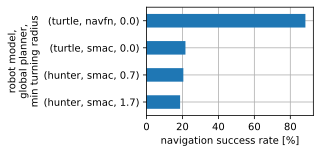

## turtle vs hunter: global planner success rate

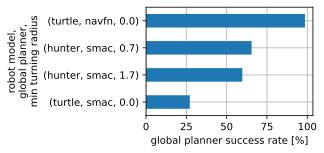

## turtle vs hunter: local planner success rate, global_planner_success_rate == 1

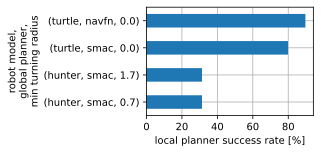

## turtle vs hunter: collision_rate, global_planner_success_rate == 1

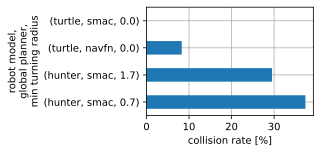

In [58]:
printmd("# Local Planner performance")

df2 = df.copy()
df2.loc[(df.robot_model == 'turtle') & (df.max_steering_angle_deg == 90), 'max_steering_angle_deg'] = np.nan

df['min_turning_radius'] = 0.65 / np.tan((df['max_steering_angle_deg']/180.0) * np.pi)
df.loc[df.min_turning_radius < 0.001, 'min_turning_radius'] = 0
df.min_turning_radius = df.min_turning_radius.apply(lambda x: int(10*x) / 10)

printmd("## turtle vs hunter: navigation success rate (TEB only)")
bar_plot(metric_name='success_rate', selected_df=df[(df.local_planner == 'teb') & (((df.robot_model == 'turtle') & (df.max_steering_angle_deg == 90)) | ((df.robot_model == 'hunter') & (df.global_planner == 'smac')))], percentage=True, higher_better=True, unit_symbol='%', 
         y_columns=['robot_model', 'global_planner', 'min_turning_radius'],
         x_metric_name='navigation success rate',
         save_fig_name="thesis_plots/bar_plots/turtle-vs-hunter-navigation-success-rate-teb-only.pdf")

printmd("## turtle vs hunter: global planner success rate")
bar_plot(metric_name='global_planner_success_rate', selected_df=df[(df.local_planner == 'teb') & (((df.robot_model == 'turtle') & (df.max_steering_angle_deg == 90)) | ((df.robot_model == 'hunter') & (df.global_planner == 'smac')))], percentage=True, higher_better=True, unit_symbol='%', 
         y_columns=['robot_model', 'global_planner', 'min_turning_radius'],# size=[3, 2/3],
         save_fig_name="thesis_plots/bar_plots/turtle-vs-hunter-global-planner-success-rate-teb-only.pdf")

printmd("## turtle vs hunter: local planner success rate, global_planner_success_rate == 1")
bar_plot(metric_name='success_rate', selected_df=df[(df.global_planner_success_rate == 1) & (df.local_planner == 'teb') & (((df.robot_model == 'turtle') & (df.max_steering_angle_deg == 90)) | ((df.robot_model == 'hunter') & (df.global_planner == 'smac')))], percentage=True, higher_better=True, unit_symbol='%', 
         y_columns=['robot_model', 'global_planner', 'min_turning_radius'],
         x_metric_name='local planner success rate',
         save_fig_name="thesis_plots/bar_plots/turtle-vs-hunter-local-planner-success-rate-teb-only.pdf")

# printmd("## turtle vs hunter: collision_rate, global_planner_success_rate == 1")
# bar_plot(metric_name='collision_rate', selected_df=df[(df.global_planner_success_rate == 1) & (df.local_planner == 'teb')], percentage=True, higher_better=False, unit_symbol='%', 
#          y_columns=['robot_model', 'global_planner', 'min_turning_radius'],
#          save_fig_name="thesis_plots/bar_plots/turtle-vs-hunter-collision-rate--only-successful-global-plan-teb-only.pdf")

printmd("## turtle vs hunter: collision_rate, global_planner_success_rate == 1")
bar_plot(metric_name='collision_rate', selected_df=df[(df.global_planner_success_rate == 1) & (df.local_planner == 'teb') & (((df.robot_model == 'turtle') & (df.max_steering_angle_deg == 90)) | ((df.robot_model == 'hunter') & (df.global_planner == 'smac')))], percentage=True, higher_better=False, unit_symbol='%', 
         y_columns=['robot_model', 'global_planner', 'min_turning_radius'],
         save_fig_name="thesis_plots/bar_plots/turtle-vs-hunter-collision-rate--only-successful-global-plan-teb-only.pdf")


In [47]:
hunter2_wheelbase = 0.65
max_steering_angle_deg = 90.0
max_steering_rad = (max_steering_angle_deg/180.0) * np.pi
float(0.65 / np.tan((max_steering_angle_deg/180.0) * np.pi))

3.980102097228898e-17